In [1]:
%matplotlib inline

## Model Inference

Here we show how to load a model for inference

In [2]:
import torch as pt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Models trained with `prehsept` can be loaded as torch script modules:

In [3]:
model = pt.jit.load('../models/xt018/pmos-20230406-083547/pmos-ulp.pt')

For comparison we will load the training data:

In [4]:
df = pd.DataFrame( pt.load('../data/xt018-pmos.pt').numpy()
                 , columns =  [ 'W','L','M','temp','region'
                               ,'vgs','vds','vbs','vth','vdsat','vearly'
                               ,'gm','gds','gmbs','self_gain','ron','rout'
                               ,'id','gmoverid','fug','betaeff','pwr'
                               ,'cgg','cgd','cgs','cgb'
                               ,'cdg','cdd','cds','cdb'
                               ,'csg','csd','css','csb'
                               ,'cbg','cbd','cbs','cbb'])

There is only one $W$ in the Data Set and we'll choose a random $L$:

In [5]:
W   = df.W[0]
L   = df.L.unique()[6] # np.random.choice(df.L.unique())
Vdd = np.max(np.abs(df['vds']))

In [6]:
Vbs = round(df['vbs'], ndigits = 2)
Vgs = round(df['vgs'], ndigits = 2)
Vds = round(df['vds'], ndigits = 2)

In [7]:
traces = df[ (df.W == W) & (df.L == L )
           & (df['region'] == 3)
           #& (df['vds'] < -10.0e-3)
           & (df['vbs'] == 0.0) 
           #& (df['vds'] == -(Vdd / 4.0))
           & (df['id'] < 0.0)
           #& (df['gmoverid'] >= 20.0)
           #& (df['gmoverid'] <= 30.0)
           ][['id', 'gmoverid', 'fug', 'vds', 'vbs', 'W', 'L']].dropna().sort_values(by=['gmoverid'])

In [21]:
traces.fug.describe()

count    7.200000e+02
mean     1.299375e+06
std      1.475266e+06
min      3.201214e+04
25%      1.536695e+05
50%      4.956187e+05
75%      2.097143e+06
max      4.736507e+06
Name: fug, dtype: float64

Next we will get the model inputs from the trace as torch tensor:

In [8]:
x = pt.from_numpy(traces[['id', 'gmoverid', 'fug', 'vds', 'vbs']].values)

... and feed it through the model

In [9]:
y = model(x)

Now we extract the results and compare them with the original data:

In [10]:
true_gmoverid = (traces['gmoverid']).values
true_id       = (traces['id']).values
true_idoverw  = (traces['id'] / traces['W']).values
true_L        = traces['L'].values
true_W        = traces['W'].values

pred_W_       = y[:,0].numpy()
pred_L_       = y[:,1].numpy()
pred_idoverw  = true_id / pred_W_

L_μ           = np.mean(pred_L_)
L_σ           = np.std(pred_L_)
L_hi          = df.L.max()
L_lo          = df.L.min()
pred_L        = np.repeat(L_μ, true_L.size)

W_μ           = np.mean(pred_W_)
W_σ           = np.std(pred_W_)
W_hi          = df.W.max()
W_lo          = df.W.min()
pred_W        = np.repeat(W_μ, true_W.size)

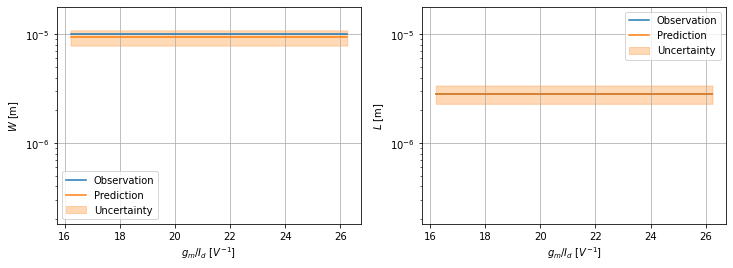

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.plot(true_gmoverid, true_W, label = "Observation")
ax1.plot(true_gmoverid, pred_W, label = "Prediction")
ax1.fill_between( true_gmoverid, (pred_W + (3 * W_σ)), (pred_W - (3 * W_σ))
                , alpha = 0.3, color = "tab:orange", label = "Uncertainty")
ax1.ticklabel_format(axis = 'both', style = 'sci', scilimits = (-2,2))
ax1.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax1.set_ylabel("$W$ [m]")
ax1.set_ylim(L_lo, L_hi)
ax1.set_yscale("log")
ax1.legend()
ax1.grid("on")

ax2.plot(true_gmoverid, true_L, label = "Observation")
ax2.plot(true_gmoverid, pred_L, label = "Prediction")
ax2.fill_between( true_gmoverid, (pred_L + (3 * L_σ)), (pred_L - (3 * L_σ))
                , alpha = 0.3, color = "tab:orange", label = "Uncertainty")
ax2.ticklabel_format(axis = 'both', style = 'sci', scilimits = (-2,2))
ax2.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax2.set_ylabel("$L$ [m]")
ax2.set_ylim(L_lo, L_hi)
ax2.set_yscale("log")
ax2.legend()
ax2.grid("on")

In [12]:
pred_L

array([2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.838643e-06,
       2.838643e-06, 2.838643e-06, 2.838643e-06, 2.8386

In [13]:
true_L

array([2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e-06,
       2.8528077e-06, 2.8528077e-06, 2.8528077e-06, 2.8528077e

In [14]:
fig.savefig('./acc.pdf')